In [1]:
!git clone https://github.com/uakarsh/latr.git

Cloning into 'latr'...
remote: Enumerating objects: 255, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 255 (delta 76), reused 67 (delta 64), pack-reused 164
Receiving objects: 100% (255/255), 2.92 MiB | 8.29 MiB/s, done.
Resolving deltas: 100% (105/105), done.


In [2]:
!pip install -r ./latr/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.7 MB/s eta 0:00:00
  Attempting uninstall: sentencepiece
    Found existing installation: sentencepiece 0.1.97
    Uninstalling sentencepiece-0.1.97:
      Successfully uninstalled sentencepiece-0.1.97


In [3]:
!sudo apt install -qqq tesseract-ocr

In [4]:
## Default Library import

import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

import json
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
import json

## For the purpose of displaying the progress of map function
tqdm.pandas()

import pytesseract
from PIL import Image, ImageDraw
from transformers import AutoTokenizer
from torchvision.transforms import ToPILImage

## Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [5]:
## Setting the hyperparameters as well as primary configurations

PAD_TOKEN_BOX = [0, 0, 0, 0]
QUESTION_BOX = [0, 0, 1000, 1000]
EOS_BOX = [0, 0, 0, 0]

max_seq_len = 512
batch_size = 2
target_size = (512,384)
t5_model = "t5-base"

tokenizer = AutoTokenizer.from_pretrained(t5_model, model_max_length = max_seq_len, use_fast = True)

In [6]:
base_path = '/kaggle/input/new-textvqa-dataset-mine'
ocr_json_path = os.path.join(base_path, 'TextVQA_Rosetta_OCR_v0.2_train.json')
train_json_path = os.path.join(base_path, 'TextVQA_0.5.1_train.json')

In [7]:
with open(ocr_json_path) as f:
    train_ocr_json = json.load(f)['data']
with open(train_json_path) as f:
    train_json = json.load(f)['data']

In [8]:
## Useful for the key-value extraction

train_json_df = pd.DataFrame(train_json)
train_ocr_json_df = pd.DataFrame(train_ocr_json)

In [9]:
train_json_df.iloc[0]

question                                     what is the brand of phone?
image_id                                                0054c91397f2fe05
image_classes          [Belt, Headphones, Goggles, Scale, Bottle open...
flickr_original_url    https://farm6.staticflickr.com/2891/9134076951...
flickr_300k_url        https://c4.staticflickr.com/3/2891/9134076951_...
image_width                                                         1024
image_height                                                         730
answers                [nokia, nokia, nokia, nokia, toshiba, nokia, n...
question_tokens                        [what, is, the, brand, of, phone]
question_id                                                            0
set_name                                                           train
Name: 0, dtype: object

In [10]:
## Converting list to string

# train_json_df['answers'] = train_json_df['answers'].apply(lambda x: " ".join(list(map(str, x))))

In [11]:
# ## Dropping of the images which doesn't exist, might take some time
# train_json_df['path_exists'] = train_json_df['image_id'].progress_apply(lambda x: os.path.exists(os.path.join(base_img_path, x)+'.jpg'))
# print("Before shape:", train_json_df.shape[0])
# train_json_df = train_json_df[train_json_df['path_exists']==True]
# print("After shape:", train_json_df.shape[0])

In [12]:
train_json_df.drop(columns = ['flickr_original_url', 'flickr_300k_url','image_classes', 'question_tokens',# 'path_exists'
                              ], axis = 1, inplace = True)

## Deleting the json

del train_json
del train_ocr_json

In [13]:
def normalize_box(box, width, height, size=1000):
    """
    Takes a bounding box and normalizes it to a thousand pixels. If you notice it is
    just like calculating percentage except takes 1000 instead of 100.
    """
    return [
        int(size * (box[0] / width)),
        int(size * (box[1] / height)),
        int(size * (box[2] / width)),
        int(size * (box[3] / height)),
    ]

In [14]:
# index = 2
# sample_entry = train_json_df.iloc[index]
# sample_ocr_entry = train_ocr_json_df[train_ocr_json_df['image_id'] == sample_entry['image_id']].values.tolist()[0][-1]

In [15]:
# ## Writing the `__getitem__` function

# width, height = sample_entry['image_width'], sample_entry['image_height']

# boxes = []
# words = []

# ## Getting the ocr and the corresponding bounding boxes
# for entry in sample_ocr_entry:
#     xmin, ymin, w, h, angle = entry['bounding_box']['top_left_x'], entry['bounding_box']['top_left_y'],  entry['bounding_box']['width'],  entry['bounding_box']['height'], entry['bounding_box']['rotation']
#     xmin, ymin,w, h = normalize_box([xmin, ymin, w, h], 1, 1, size = 1000)

#     xmax = xmin + w
#     ymax = ymin + h

#     ## Bounding boxes are normalized
#     curr_bbox = [xmin, ymin, xmax, ymax]
#     boxes.append(curr_bbox)
#     words.append(entry['word'])

In [16]:
# ## For clarity

# actual_img = Image.open(os.path.join(base_img_path, sample_entry['image_id'])+'.jpg').resize((1000, 1000))
# draw_on_img = ImageDraw.Draw(actual_img)  

# for box in boxes:
#   draw_on_img.rectangle(box, outline ="red")
# actual_img

In [17]:
## Reference: https://github.com/uakarsh/TiLT-Implementation/blob/main/src/dataset.py

def get_tokens_with_boxes(unnormalized_word_boxes, list_of_words, tokenizer, pad_token_box = [0, 0, 0, 0], max_seq_len = 512):
    ## 2. Performing the semantic pre-processing
    encoding = tokenizer(list_of_words, is_split_into_words = True, add_special_tokens = False)

    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']

    ## Note that, there is no need for bboxes, since the model does not use bbox as feature, so no pre-processing of that
    bbox_according_to_tokenizer = [unnormalized_word_boxes[i] for i in encoding.word_ids()]

    # Truncation of token_boxes + token_labels
    special_tokens_count = 1
    if len(input_ids) > max_seq_len - special_tokens_count:
        bbox_according_to_tokenizer = bbox_according_to_tokenizer[: (max_seq_len - special_tokens_count)]
        input_ids = input_ids[: (max_seq_len - special_tokens_count)]
        attention_mask = attention_mask[: (max_seq_len - special_tokens_count)]

    
    ## Padding
    input_ids =  input_ids + [tokenizer.eos_token_id]
    bbox_according_to_tokenizer = bbox_according_to_tokenizer + [pad_token_box]
    attention_mask = attention_mask + [1]
    
    pad_length = max_seq_len -  len(input_ids)

    input_ids = input_ids + [tokenizer.pad_token_id] * (pad_length)
    bbox_according_to_tokenizer = bbox_according_to_tokenizer + [pad_token_box] * (pad_length)
    attention_mask = attention_mask + [0] * (pad_length)
    
    return input_ids, bbox_according_to_tokenizer, attention_mask


def create_features(
    img_path,
    tokenizer,
    target_size = (1000, 1000),
    max_seq_length=512,
    use_ocr = True,
    bounding_box = None,
    words = None,
    pad_token_box = [0, 0, 0, 0]
    ):
  
  '''
  We assume that the bounding box provided are given as per the image scale (i.e not normalized), so that we just need to scale it as per the ratio
  '''

  img = Image.open(img_path).convert("RGB")
  width_old, height_old = img.size
  img = img.resize(target_size)
  width, height = img.size
  
  ## Rescaling the bounding box as per the image size
  if (use_ocr == False) and (bounding_box == None or words == None):
    raise Exception('Please provide the bounding box and words or pass the argument "use_ocr" = True')

  if use_ocr == True:
    entries = apply_ocr(img_path)
    bounding_box = entries["bbox"]
    words = entries["words"]
    bounding_box = list(map(lambda x: normalize_box(x,width_old,height_old), bounding_box))

  tokenized_words, boxes, attention_mask = get_tokens_with_boxes(bounding_box, words, tokenizer,
                                                                pad_token_box, max_seq_len = max_seq_length)


  return img, boxes, tokenized_words, attention_mask

In [18]:
# img, boxes, tokenized_words, attention_mask = create_features(img_path = os.path.join(base_img_path, sample_entry['image_id'])+'.jpg', 
#                                              tokenizer = tokenizer, use_ocr = False, words = words, bounding_box = boxes)

In [19]:
# ## For clarity

# actual_img = img
# draw_on_img = ImageDraw.Draw(actual_img)  

# for box in boxes:
#   draw_on_img.rectangle(box, outline ="red")

# actual_img

In [20]:
# sample_entry

In [21]:
## Defining the pytorch dataset

from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms

class TextVQA(Dataset):
  def __init__(self, base_img_path, json_df, ocr_json_df, tokenizer, transform = None, max_seq_length = 512, target_size = (512,384)):

    self.base_img_path = base_img_path
    self.json_df = json_df
    self.ocr_json_df = ocr_json_df
    self.tokenizer = tokenizer
    self.target_size = target_size
    self.transform = transform
    self.max_seq_length = max_seq_length

  def __len__(self):
    return len(self.json_df)

  def __getitem__(self, index):
    
    sample_entry = self.json_df.iloc[index]
    sample_ocr_entry = self.ocr_json_df[self.ocr_json_df['image_id'] == sample_entry['image_id']].values.tolist()[0][-1]
    
    width, height = sample_entry['image_width'], sample_entry['image_height']

    boxes = []
    words = []

    ## Getting the ocr and the corresponding bounding boxes
    for entry in sample_ocr_entry:
        xmin, ymin, w, h, angle = entry['bounding_box']['top_left_x'], entry['bounding_box']['top_left_y'],  entry['bounding_box']['width'],  entry['bounding_box']['height'], entry['bounding_box']['rotation']
        xmin, ymin,w, h = normalize_box([xmin, ymin, w, h], 1, 1, size = 1000)

        xmax = xmin + w
        ymax = ymin + h

        ## Bounding boxes are normalized
        curr_bbox = [xmin, ymin, xmax, ymax]
        boxes.append(curr_bbox)
        words.append(entry['word'])
    
    img_path = os.path.join(self.base_img_path, sample_entry['image_id'])+'.jpg'  ## Adding .jpg at end of the image, as the grouped key does not have the extension format 

    assert os.path.exists(img_path)==True, f'Make sure that the image exists at {img_path}!!'
    ## Extracting the feature
    img, boxes, tokenized_words, attention_mask = create_features(img_path = img_path, 
                                             tokenizer = self.tokenizer, use_ocr = False, words = words, bounding_box = boxes,
                                                                 target_size = self.target_size)
    
    ## Converting the boxes as per the format required for model input
    boxes = torch.as_tensor(boxes, dtype=torch.int32)
#     width = (boxes[:, 2] - boxes[:, 0]).view(-1, 1)
#     height = (boxes[:, 3] - boxes[:, 1]).view(-1, 1)
#     boxes = torch.cat([boxes, width, height], axis = -1)

    ## Tensor tokenized words
    tokenized_words = torch.as_tensor(tokenized_words, dtype=torch.int32)

    if self.transform is not None:
      img = self.transform(img)
    else:
      img = transforms.ToTensor()(img)


    ## Getting the Question
    question = sample_entry['question']   
    # question = self.tokenizer(question)['input_ids']

    ## Getting the Answer
    answer = sample_entry['answers']
    #answer = self.tokenizer(answer)['input_ids']

    return {'img':img, 'boxes': boxes, 'tokenized_words': tokenized_words, 'question': question, 'answer': answer}

In [22]:
base_img_path = os.path.join(base_path, 'train_val_images', 'train_images')

In [23]:
train_ds = TextVQA(base_img_path = base_img_path,
                   json_df = train_json_df,
                   ocr_json_df = train_ocr_json_df,
                   tokenizer = tokenizer,
                   transform = None, 
                   max_seq_length = max_seq_len, 
                   #target_size = (1000, 1000)
                   )

In [24]:
# index = 6
# sample_entry = train_json_df.iloc[index]
# sample_ocr_entry = train_ocr_json_df[train_ocr_json_df['image_id'] == sample_entry['image_id']]

In [25]:
# sample_ocr_entry

In [26]:
# train_ocr_json_df[train_json_df['image_id'] == sample_entry['image_id']]

In [27]:
# train_json_df[train_json_df['image_id'] == sample_entry['image_id']]

In [28]:
index = 65
encoding = train_ds[index]  ## Might take time as per the processing
boxes = encoding['boxes']

In [29]:
print(f"Question is : {encoding['question']}")
print(f"Answer is : {encoding['answer']}")

Question is : is that plane part of the star alliance?
Answer is : ['yes', 'yes', 'star alliance', 'yes', 'yes', 'yes', 'sunkist', 'yes', 'yes', 'stop']


In [30]:
pil_image = ToPILImage()(encoding['img']).resize((1000, 1000))

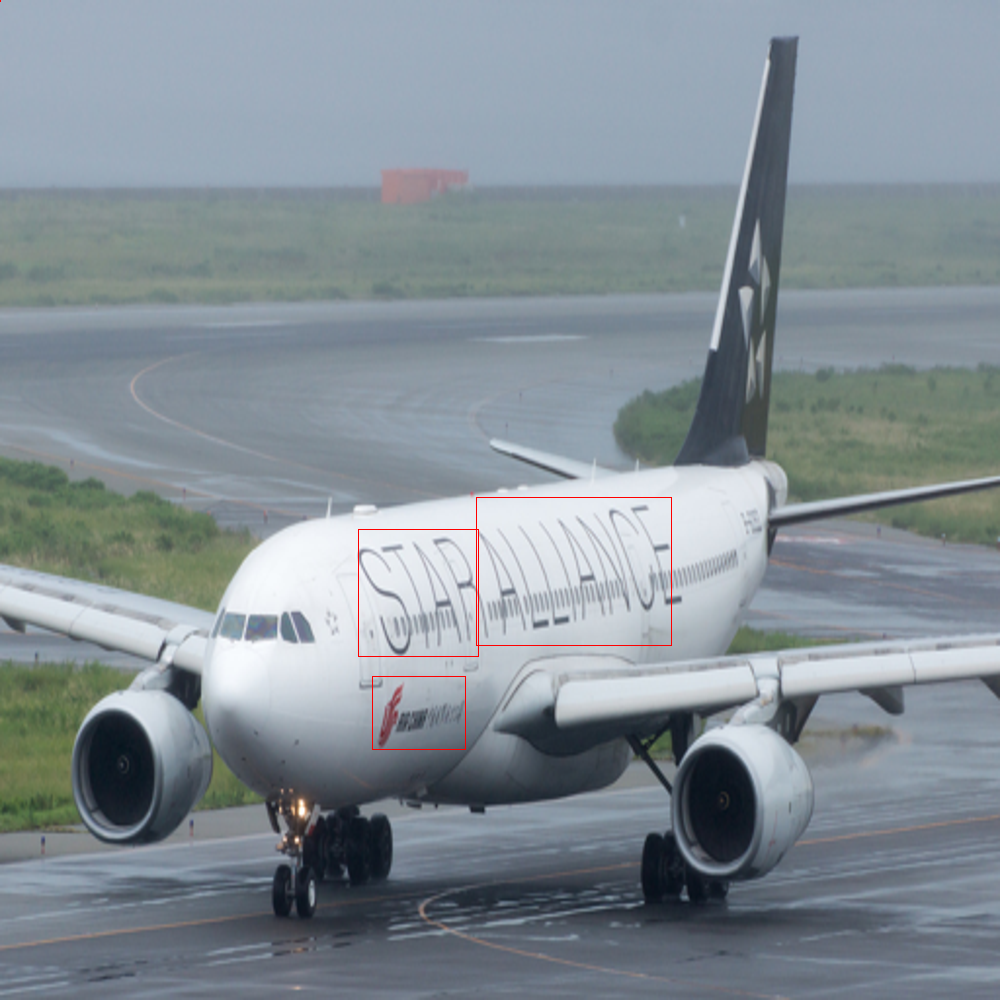

In [31]:
## Foracoscopy clarity

actual_img = pil_image
draw_on_img = ImageDraw.Draw(actual_img)  

for box in boxes:
  draw_on_img.rectangle(box.tolist()[:4], outline ="red")

actual_img